Random Forest for predicting the ride duration for a bike check-out.
Understanding the dataset...


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# Setting seed for reproducibility
np.random.seed(4242)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import random
import joblib

from sklearn.metrics import accuracy_score, precision_score, mean_squared_error, r2_score

#use this cell to import additional libraries or define helper functions
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv("combined_tripdata.csv")

Data Cleaning

In [4]:
df.dropna()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86.0,Lincoln Ave & Diversey Pkwy,152.0,41.896400,-87.661000,41.932200,-87.658600,member
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503.0,Kosciuszko Park,499.0,41.924400,-87.715400,41.930600,-87.723800,member
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142.0,Indiana Ave & Roosevelt Rd,255.0,41.894500,-87.617900,41.867900,-87.623000,member
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216.0,Wood St & Augusta Blvd,657.0,41.903000,-87.697500,41.899200,-87.672200,member
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125.0,Sheridan Rd & Lawrence Ave,323.0,41.890200,-87.626200,41.969500,-87.654700,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25256673,36DAF3C93190E07F,classic_bike,2024-12-13 15:40:06.123,2024-12-13 15:46:29.553,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member
25256675,71F02C3CF79B8090,classic_bike,2024-12-17 08:09:12.581,2024-12-17 08:15:50.134,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member
25256676,85AE8840FA0E4EAB,classic_bike,2024-12-18 08:22:40.737,2024-12-18 08:29:25.021,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member
25256679,15602635C5DF484E,electric_bike,2024-12-31 17:10:03.113,2024-12-31 17:17:21.838,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member


In [5]:
#Data type conversions
df['rideable_type'] = df.rideable_type.astype('category')
df['member_casual'] = df.member_casual.astype('category')
df['start_station_id'] = df.start_station_id.astype('category')
df['end_station_id'] = df.end_station_id.astype('category')

In [6]:
df['started_at'] = pd.to_datetime(df['started_at'], infer_datetime_format=True, format='mixed')
df['ended_at'] = pd.to_datetime(df['ended_at'], infer_datetime_format=True, format='mixed')

In [7]:
#categorize rideable_type
df['conv_rideable_type'] = 'NaN'
df.loc[df['rideable_type'] == 'docked_bike', 'conv_rideable_type'] = 0
df.loc[df['rideable_type'] == 'electric_bike', 'conv_rideable_type'] = 1
df.loc[df['rideable_type'] == 'classic_bike', 'conv_rideable_type'] = 2
df.loc[df['rideable_type'] == 'electric_scooter', 'conv_rideable_type'] = 3

In [8]:
#categorize member_casual
df['conv_member_casual'] = 'NaN'
df.loc[df['member_casual'] == 'casual', 'conv_member_casual'] = 0
df.loc[df['member_casual'] == 'member', 'conv_member_casual'] = 1

In [9]:
#make trip_duration column <- this is the dependent variable/feature
df['trip_duration'] = df['ended_at'] - df['started_at']
df['trip_duration'] = df['trip_duration'].astype('timedelta64[s]')
df['trip_duration'] = df['trip_duration'] / np.timedelta64(1, 'm')
df['trip_duration'] = round(df['trip_duration'],2)

In [10]:
#create Month Label Encoding
df['January'] = 0
df['February'] = 0
df['March'] = 0
df['April'] = 0
df['May'] = 0
df['June'] = 0
df['July'] = 0
df['August'] = 0
df['September'] = 0
df['October'] = 0
df['November'] = 0
df['December'] = 0

df.loc[df['started_at'].dt.month_name() == 'January', 'January'] = 1
df.loc[df['started_at'].dt.month_name() == 'February', 'February'] = 1
df.loc[df['started_at'].dt.month_name()== 'March', 'March'] = 1
df.loc[df['started_at'].dt.month_name() == 'April', 'April'] = 1
df.loc[df['started_at'].dt.month_name() == 'May', 'May'] = 1
df.loc[df['started_at'].dt.month_name() == 'June', 'June'] = 1
df.loc[df['started_at'].dt.month_name() == 'July', 'July'] = 1
df.loc[df['started_at'].dt.month_name() == 'August', 'August'] = 1
df.loc[df['started_at'].dt.month_name() == 'September', 'September'] = 1
df.loc[df['started_at'].dt.month_name() == 'October', 'October'] = 1
df.loc[df['started_at'].dt.month_name() == 'November', 'November'] = 1
df.loc[df['started_at'].dt.month_name() == 'December', 'December'] = 1

In [11]:
#create DayOfWeek Label Encoding

df['Monday'] = 0
df['Tuesday'] = 0
df['Wednesday'] = 0
df['Thursday'] = 0
df['Friday'] = 0
df['Saturday'] = 0
df['Sunday'] = 0

df.loc[df['started_at'].dt.day_name() == 'Monday', 'Monday'] = 1
df.loc[df['started_at'].dt.day_name() == 'Tuesday', 'Tuesday'] = 1
df.loc[df['started_at'].dt.day_name()== 'Wednesday', 'Wednesday'] = 1
df.loc[df['started_at'].dt.day_name() == 'Thursday', 'Thursday'] = 1
df.loc[df['started_at'].dt.day_name() == 'Friday', 'Friday'] = 1
df.loc[df['started_at'].dt.day_name() == 'Saturday', 'Saturday'] = 1
df.loc[df['started_at'].dt.day_name() == 'Sunday', 'Sunday'] = 1

In [12]:
#create TimeOfDay Label Encoding

df['late_night'] = 0
df['early_morning'] = 0
df['noon'] = 0
df['rush_hour'] = 0
df['afternoon'] = 0
df['night'] = 0

df.loc[(df['started_at'].dt.hour < 7), 'late_night'] = 1
df.loc[(df['started_at'].dt.hour >= 7) & (df['started_at'].dt.hour < 12), 'early_morning'] = 1
df.loc[(df['started_at'].dt.hour >= 12) & (df['started_at'].dt.hour < 16), 'noon'] = 1
df.loc[(df['started_at'].dt.hour >= 16) & (df['started_at'].dt.hour < 19), 'rush_hour'] = 1
df.loc[(df['started_at'].dt.hour >= 19) & (df['started_at'].dt.hour < 21), 'afternoon'] = 1
df.loc[(df['started_at'].dt.hour >= 21), 'night'] = 1

In [13]:
Y = pd.to_numeric(df['trip_duration'], errors='coerce')

In [14]:
Y.shape

(25256682,)

In [15]:
Y.dropna()

0           26.82
1            8.15
2           14.38
3           12.20
4           52.92
            ...  
25256677    13.78
25256678    11.28
25256679     7.30
25256680     5.57
25256681     7.90
Name: trip_duration, Length: 25256682, dtype: float64

In [16]:
Y.shape

(25256682,)

In [17]:
feat_cols = ['start_lat', 'start_lng', 'end_lat', 'end_lng', 'conv_rideable_type', 'conv_member_casual',
            'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December',
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'late_night', 'early_morning', 'noon', 'rush_hour', 'afternoon', 'night']

df = df[feat_cols]

In [18]:
#split data subset 80/20 for train/validation

X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, shuffle=False)

In [19]:
X_train.tail(5)

,start_lat,start_lng,end_lat,end_lng,conv_rideable_type,conv_member_casual,January,February,March,April,...,Thursday,Friday,Saturday,Sunday,late_night,early_morning,noon,rush_hour,afternoon,night
20205340,41.95,-87.65,41.940232,-87.652944,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
20205341,41.94,-87.65,41.921822,-87.644140,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
20205342,41.92,-87.67,41.889177,-87.638506,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
20205343,41.90,-87.66,41.889177,-87.638506,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
20205344,41.89,-87.64,41.889177,-87.638506,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [20]:
y_train.head(5)

0    26.82
1     8.15
2    14.38
3    12.20
4    52.92
Name: trip_duration, dtype: float64

Model Building

In [23]:
# Import the model we are using
#model = RandomForestRegressor(n_estimators = 100, verbose=2, max_depth=19, n_jobs=-1)  # Regressor instead of Classifier
#model.fit(X_train, y_train)  # y_train should be continuous values

In [24]:
# save
#joblib.dump(model, "drive/MyDrive/Divvy/random_forest_divvy_100_depth_two.joblib", compress=3)

In [21]:
# load
model = joblib.load("random_forest_divvy_100.joblib")

# Use the forest's predict method on the test data
predictions = model.predict(X_test)# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.9s


Mean Absolute Error: 11.33 degrees.
Mean Squared Error: 1050.7190061564072
R-squared: 0.7184187690185615


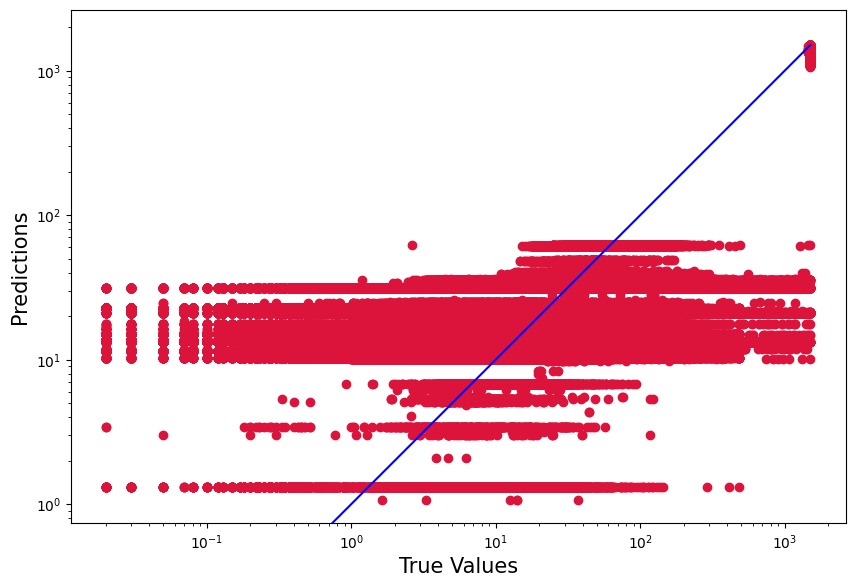

In [ ]:
#https://stackoverflow.com/questions/58410187/how-to-plot-predicted-values-vs-the-true-value

plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.show()

In [35]:
# load
model = joblib.load("random_forest_divvy_100_depth.joblib")

# Use the forest's predict method on the test data
predictions = model.predict(X_test)# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.


Mean Absolute Error: 10.25 degrees.
Mean Squared Error: 1299.3072476273715
R-squared: 0.6517998322421523


[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    2.7s finished


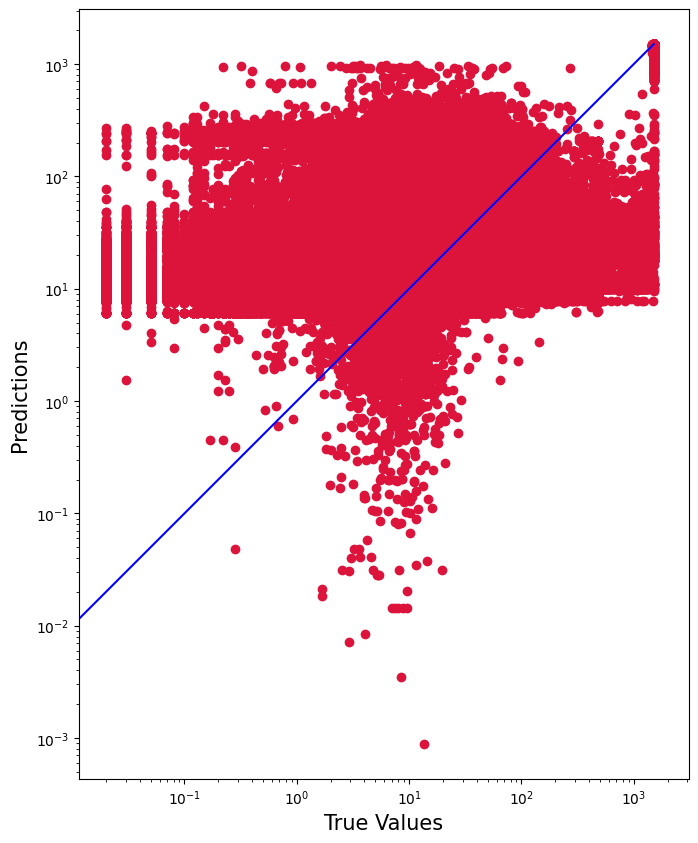

In [36]:
#https://stackoverflow.com/questions/58410187/how-to-plot-predicted-values-vs-the-true-value

plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.show()

In [39]:
# load
model = joblib.load("random_forest_divvy_100_depth_two.joblib")

# Use the forest's predict method on the test data
predictions = model.predict(X_test)# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.


Mean Absolute Error: 9.94 degrees.
Mean Squared Error: 1679.6937002781078
R-squared: 0.5498604127032686


[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    5.1s finished


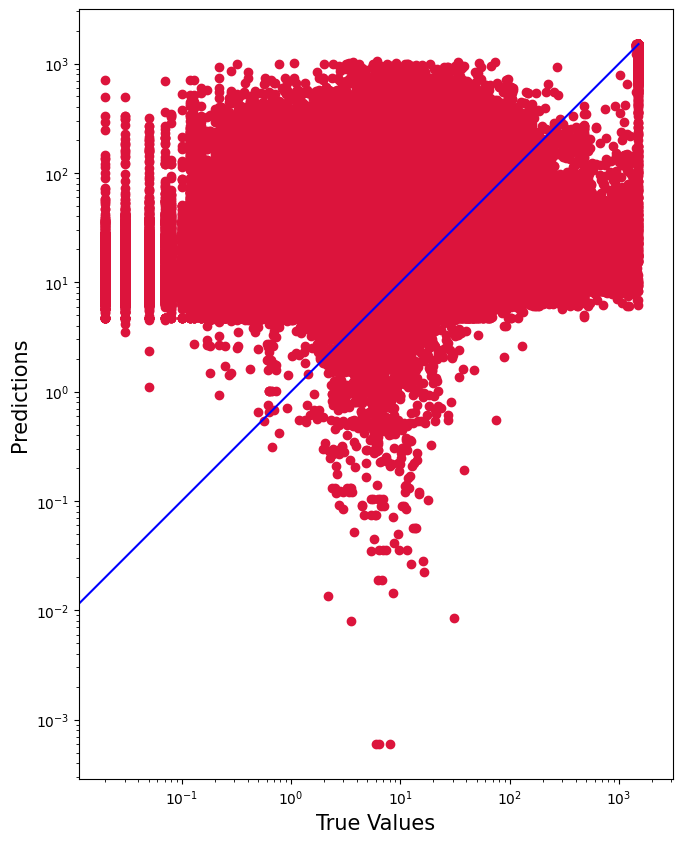

In [40]:
#https://stackoverflow.com/questions/58410187/how-to-plot-predicted-values-vs-the-true-value

plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.show()